<a href="https://colab.research.google.com/github/ganesh3/pytorch-work/blob/master/interpreting_tree_ensemble_models_using_functional_ANOVA_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Any, Optional, Union
import xgboost as xgb
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm
import json

@dataclass
class EffectRule:
    splits: Dict[str, Dict[str, float]]
    value: float

class TreeEnsembleInterpreter:
    def __init__(self, model, feature_names=None):
        if not isinstance(model, (xgb.XGBModel, xgb.core.Booster)):
            raise ValueError("Currently only XGBoost models are supported")

        self.model = model
        self.feature_names = feature_names
        self.feature_map = {str(i): name for i, name in enumerate(feature_names)}
        self.effects = {}
        self.importance_scores = {}

    def _get_booster(self):
        """Get the booster object from the model."""
        if isinstance(self.model, xgb.core.Booster):
            return self.model
        return self.model.get_booster()

    def _parse_tree_json(self, tree_str):
        tree_dict = json.loads(tree_str)

        def parse_node(node):
            if 'leaf' in node:
                return {'leaf_value': float(node['leaf'])}

            # Get feature name from either index or direct name
            split = node['split']
            if split in self.feature_map:
                feature_name = self.feature_map[split]
            else:
                feature_name = split  # Already a feature name

            return {
                'split_feature': feature_name,
                'split_value': float(node['split_condition']),
                'left': parse_node(node['children'][0]),
                'right': parse_node(node['children'][1])
            }

        return parse_node(tree_dict)

    def _extract_paths(self, tree):
        """Extract paths with improved effect handling."""
        paths = []

        def traverse(node, current_path, splits):
            if 'leaf_value' in node:
                # Handle single-feature splits as main effects
                unique_features = set(feat for feat, _, _ in current_path)
                if len(current_path) == 1 or len(unique_features) == 1:
                    # This is a main effect
                    feature = current_path[0][0] if current_path else None
                    if feature:
                        paths.append({
                            'leaf_value': node['leaf_value'],
                            'path': [(feature, None, None)],
                            'splits': {feature: splits[feature]} if feature in splits else {}
                        })
                else:
                    # This is an interaction effect
                    paths.append({
                        'leaf_value': node['leaf_value'],
                        'path': current_path.copy(),
                        'splits': splits.copy()
                    })
                return

            feature = node['split_feature']
            value = node['split_value']

            # Left path (<=)
            new_splits = splits.copy()
            if feature not in new_splits:
                new_splits[feature] = {'upper': float('inf'), 'lower': float('-inf')}
            new_splits[feature]['upper'] = min(new_splits[feature]['upper'], value)
            traverse(node['left'], current_path + [(feature, '<=', value)], new_splits)

            # Right path (>)
            new_splits = splits.copy()
            if feature not in new_splits:
                new_splits[feature] = {'upper': float('inf'), 'lower': float('-inf')}
            new_splits[feature]['lower'] = max(new_splits[feature]['lower'], value)
            traverse(node['right'], current_path + [(feature, '>', value)], new_splits)

        traverse(tree, [], {})
        return paths

    def decompose(self, verbose=True):
        try:
            # Get trees in JSON format
            booster = self._get_booster()
            trees = booster.get_dump(dump_format='json')

            if verbose:
                print(f"Processing {len(trees)} trees...")

            main_effects = {}
            interaction_effects = {}

            for tree_str in tqdm(trees):
                tree_struct = self._parse_tree_json(tree_str)
                paths = self._extract_paths(tree_struct)

                for path in paths:
                    features = tuple(sorted(set(feat for feat, _, _ in path['path'])))

                    if not features:  # Skip empty feature sets
                        continue

                    if len(features) == 1:  # Main effect
                        if features not in main_effects:
                            main_effects[features] = []
                        main_effects[features].append(
                            EffectRule(splits=path['splits'], value=path['leaf_value'])
                        )
                    else:  # Interaction effect
                        if features not in interaction_effects:
                            interaction_effects[features] = []
                        interaction_effects[features].append(
                            EffectRule(splits=path['splits'], value=path['leaf_value'])
                        )

            # Combine effects
            self.effects = {**main_effects, **interaction_effects}

            if verbose:
                print("\nFound effects:")
                print(f"Main effects: {len(main_effects)}")
                print(f"Interaction effects: {len(interaction_effects)}")

        except Exception as e:
            print(f"Error during decomposition: {str(e)}")
            raise

    def calculate_importance(self):
        if not self.effects:
            print("Warning: No effects found. Run decompose() first.")
            return

        total_variance = 0
        for effect_key, effect_rules in self.effects.items():
            values = [rule.value for rule in effect_rules]
            if values:  # Only calculate if we have values
                variance = np.var(values)
                self.importance_scores[effect_key] = variance
                total_variance += variance

        # Normalize scores
        if total_variance > 0:
            for key in self.importance_scores:
                self.importance_scores[key] /= total_variance

    def summary(self):
        if not self.importance_scores:
            print("Warning: No importance scores found. Run calculate_importance() first.")
            return pd.DataFrame()

        data = []
        for effect_key, importance in self.importance_scores.items():
            data.append({
                'Effect': ' × '.join(effect_key),
                'Order': len(effect_key),
                'Importance': importance,
                'Num_Rules': len(self.effects[effect_key])
            })

        df = pd.DataFrame(data)
        if not df.empty:
            return df.sort_values('Importance', ascending=False)
        return df

    def plot_main_effect(self, feature, fig_size=(10, 6)):
        if (feature,) not in self.effects:
            print(f"Warning: No main effect found for feature {feature}")
            return

        effect = self.effects[(feature,)]

        # Get unique split points
        splits = sorted(set(
            split_val
            for rule in effect
            for split_val in [rule.splits[feature]['lower'], rule.splits[feature]['upper']]
            if split_val not in [float('-inf'), float('inf')]
        ))

        if not splits:
            print(f"Warning: No split points found for feature {feature}")
            return

        values = []
        for split_point in splits:
            relevant_rules = [
                rule for rule in effect
                if rule.splits[feature]['lower'] <= split_point < rule.splits[feature]['upper']
            ]
            if relevant_rules:
                values.append(np.mean([rule.value for rule in relevant_rules]))
            else:
                values.append(0)

        plt.figure(figsize=fig_size)
        plt.plot(splits, values, '-o')
        importance = self.importance_scores.get((feature,), 0)
        plt.title(f'Main Effect: {feature} (Importance: {importance:.3f})')
        plt.xlabel(feature)
        plt.ylabel('Effect Value')
        plt.grid(True)
        plt.show()

    def debug_tree_structure(self, num_trees=1):
        """Debug method to print the structure of the first few trees."""
        booster = self._get_booster()
        trees = booster.get_dump(dump_format='json')

        print(f"\nDebug: Examining first {num_trees} trees")
        for i, tree_str in enumerate(trees[:num_trees]):
            print(f"\nTree {i}:")
            tree_dict = json.loads(tree_str)
            print("Raw tree structure:", tree_dict)
            print("\nParsed structure:")
            self._print_tree_structure(tree_dict)

    def _print_tree_structure(self, node, prefix="", is_left=True):
        """Helper method to print tree structure recursively."""
        if 'leaf' in node:
            print(prefix + ('└── ' if is_left else '┌── ') + f"Leaf: {node['leaf']}")
            return

        split = node['split']
        if split in self.feature_map:
            feature_name = self.feature_map[split]
        else:
            feature_name = split

        print(prefix + ('└── ' if is_left else '┌── ') +
              f"Split on {feature_name} @ {node['split_condition']}")

        prefix += "    " if is_left else "│   "
        self._print_tree_structure(node['children'][0], prefix, True)
        self._print_tree_structure(node['children'][1], prefix, False)

    def plot_effects_summary(self):
        """Plot a summary of all effects."""
        if not self.importance_scores:
            print("No importance scores available. Run calculate_importance() first.")
            return

        effects = list(self.importance_scores.keys())
        importances = list(self.importance_scores.values())

        # Sort by importance
        sorted_idx = np.argsort(importances)
        effects = [effects[i] for i in sorted_idx]
        importances = [importances[i] for i in sorted_idx]

        # Create labels
        labels = [' × '.join(effect) for effect in effects]

        plt.figure(figsize=(12, 6))
        plt.barh(range(len(importances)), importances)
        plt.yticks(range(len(importances)), labels)
        plt.xlabel('Importance')
        plt.title('Effect Importance Summary')
        plt.grid(True, axis='x')
        plt.tight_layout()
        plt.show()

In [84]:
def create_friedman_dataset(n_samples=2000, noise=0.1, random_state=None):
    """Create the Friedman dataset."""
    if random_state is not None:
        np.random.seed(random_state)

    X = np.random.uniform(0, 1, (n_samples, 10))
    y = (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) +
         20 * (X[:, 2] - 0.5)**2 +
         10 * X[:, 3] +
         5 * X[:, 4] +
         np.random.normal(0, noise, n_samples))

    return pd.DataFrame(X, columns=[f"X{i+1}" for i in range(10)]), y

In [85]:
def run_example(n_samples=2000, random_state=42):
    """Run example with simulated data."""
    # Create dataset
    print("Creating dataset...")
    X, y = create_friedman_dataset(n_samples=n_samples, random_state=random_state)
    print(f"Created dataset with {len(X)} samples and {len(X.columns)} features")

    # Train model
    print("\nTraining XGBoost model...")
    feature_names = X.columns.tolist()
    dtrain = xgb.DMatrix(X, label=y, feature_names=feature_names)

    # Train model
    params = {
        'max_depth': 2,
        'eta': 0.01,
        'objective': 'reg:squarederror',
        'random_state': random_state
    }
    model = xgb.train(params, dtrain, num_boost_round=100)

    # Create interpreter
    print("\nInterpreting model...")
    interpreter = TreeEnsembleInterpreter(model, feature_names=feature_names)

    # Decompose and analyze
    interpreter.decompose(verbose=True)
    interpreter.calculate_importance()

    # Show summary
    print("\nEffect Summary:")
    summary = interpreter.summary()
    if not summary.empty:
        print(summary.to_string())
        interpreter.plot_effects_summary()

    # Plot effects
    print("\nPlotting main effects...")
    for feature in ['X1', 'X2', 'X3', 'X4', 'X5']:
        if (feature,) in interpreter.effects:
            print(f"\nPlotting main effect for {feature}")
            interpreter.plot_main_effect(feature)

    return interpreter

Creating dataset...
Created dataset with 2000 samples and 10 features

Training XGBoost model...

Interpreting model...
Processing 100 trees...


100%|██████████| 100/100 [00:00<00:00, 12205.16it/s]


Found effects:
Main effects: 0
Interaction effects: 4

Effect Summary:
    Effect  Order  Importance  Num_Rules
0  X2 × X4      2    0.331094        198
1  X1 × X4      2    0.269521        158
3  X4 × X5      2    0.202659         10
2  X1 × X2      2    0.196727         34


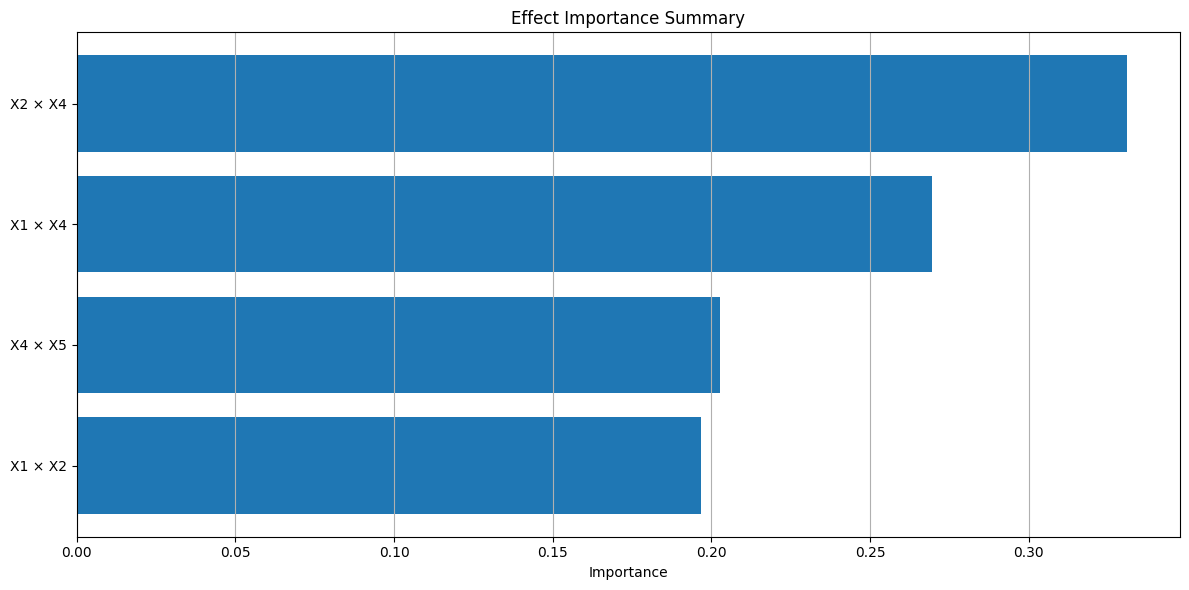


Plotting main effects...


In [86]:
if __name__ == "__main__":
    interpreter = run_example()